In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from __future__ import print_function, division

import torch
import torchvision

In [5]:
from torchsummary import summary

In [6]:
import time
import copy

# 准备数据

In [7]:
path = Path('../../../data/dogs-vs-cats/sample')

In [8]:
path.ls()

[PosixPath('../../../data/dogs-vs-cats/sample/train'),
 PosixPath('../../../data/dogs-vs-cats/sample/valid')]

In [9]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

    data_transforms = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
https://discuss.pytorch.org/t/transfer-learning-usage-with-different-input-size/20744
上面的帖子说对于不同的输入size也许训练完成的模型性能不同，暂时使用相同的输入size
在train中使用Resize(224)而不是RandomResizedCrop(224)会报错，暂不知道原因
在train中使用Resize(224)而不是Resize(256)加CenterCrop(224)会报错，暂不知道原因

In [10]:
dirs = ['train', 'valid']

In [11]:
image_datasets = {x: torchvision.datasets.ImageFolder(path/x, data_transforms[x]) for x in dirs}

In [12]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=8, 
                                              shuffle=True, 
                                              num_workers=6) 
               for x in dirs}

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in dirs}

In [14]:
class_names = image_datasets['train'].classes

In [15]:
class_names

['cat', 'dog']

In [16]:
image_datasets['train'].class_to_idx

{'cat': 0, 'dog': 1}

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

# 可视化训练数据

In [19]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is not None:
        ax.imshow(inp)
        if title is not None:
            ax.set_title(title)
    else:
        plt.imshow(inp, aspect='equal')
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated

4


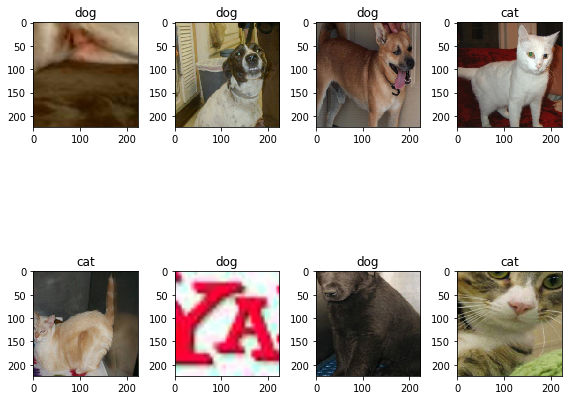

In [20]:
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in classes])
# imshow(out, title=str(classes))
column = round(len(classes)//2)
print(column)
fig, axs = plt.subplots(2, column, figsize=(8, 8))
for i, class_ind in enumerate(classes):
    ax = axs[i//column][i%column]
    imshow(inputs.cpu().data[i], ax=ax, title=class_names[class_ind])
plt.tight_layout()

# 训练模型

In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=8):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #深度拷贝模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    print()
    time_elapsed = time.time() - since
    print('Trainig complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #加载准确率最好的模型参数
    model.load_state_dict(best_model_wts)
    return model

# 可视化模型预测

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(num_images//2, 2, figsize=(6, 6))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                ax = axs[images_so_far//2][images_so_far%2]
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], ax=ax)
                
                images_so_far += 1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 微调

In [23]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft_fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.5459 Acc: 0.8275
valid Loss: 0.1318 Acc: 0.9512
Epoch 1/15
----------
train Loss: 0.3031 Acc: 0.8712
valid Loss: 0.0753 Acc: 0.9768
Epoch 2/15
----------
train Loss: 0.2393 Acc: 0.9027
valid Loss: 0.0574 Acc: 0.9800
Epoch 3/15
----------
train Loss: 0.2096 Acc: 0.9163
valid Loss: 0.0577 Acc: 0.9808
Epoch 4/15
----------
train Loss: 0.2317 Acc: 0.9067
valid Loss: 0.0433 Acc: 0.9800
Epoch 5/15
----------
train Loss: 0.2075 Acc: 0.9136
valid Loss: 0.0810 Acc: 0.9696
Epoch 6/15
----------
train Loss: 0.1948 Acc: 0.9224
valid Loss: 0.0584 Acc: 0.9784
Epoch 7/15
----------
train Loss: 0.1524 Acc: 0.9379
valid Loss: 0.0519 Acc: 0.9824
Epoch 8/15
----------
train Loss: 0.1326 Acc: 0.9469
valid Loss: 0.0422 Acc: 0.9816
Epoch 9/15
----------
train Loss: 0.1493 Acc: 0.9421
valid Loss: 0.0420 Acc: 0.9840
Epoch 10/15
----------
train Loss: 0.1485 Acc: 0.9416
valid Loss: 0.0363 Acc: 0.9848
Epoch 11/15
----------
train Loss: 0.1380 Acc: 0.9483
valid Loss: 0.0398 Ac

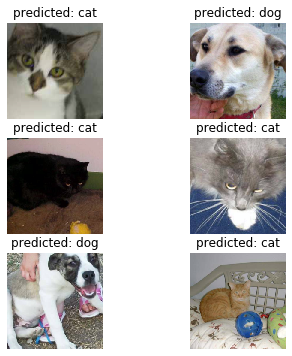

In [25]:
visualize_model(model_ft)

In [26]:
summary(model_ft, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,